In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import os
import random
from tqdm import tqdm
import math
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Identity
from transformers import PatchTSMixerConfig, PatchTSMixerForTimeSeriesClassification
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR

D:\Anaconda_3\envs\GPU-pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: cuda


In [3]:
def set_seed(seed=42):
    """Set seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(42)

#### import training and testing data

In [4]:
ws = 10
file_train_samples = f'PatchTST_dataset/train_samples_signature_label4marker_6000_7000_ws{ws}.npy'
file_train_tops = f'PatchTST_dataset/train_tops_signature_label4marker_6000_7000_ws{ws}.npy'
file_test_samples = f'PatchTST_dataset/test_samples_label4marker_6000_7000_ws{ws}_100.npy'
file_test_tops = f'PatchTST_dataset/test_tops_label4marker_6000_7000_ws{ws}_100.npy'

In [5]:
samples_train = np.load(file_train_samples)
tops_train = np.load(file_train_tops)
samples_test = np.load(file_test_samples)
tops_test = np.load(file_test_tops)
print(samples_train.shape)
print(samples_test.shape)
print(tops_train.shape)
print(tops_test.shape)

(321, 2000, 3)
(100, 2000, 3)
(321, 3)
(100, 3)


#### prepare dataset and dataloader

In [6]:
#### calculate mean and std for train set
def mean_std(samples):
    gr_values = samples[:,:,1].copy()
    mean = np.mean(gr_values)
    std = np.std(gr_values)
    return mean, std

def normalize(samples):
    gr_values = samples[:,:,1].copy()
    normalized_gr_values = (gr_values - train_mean) / train_std
    samples[:, :, 1] = normalized_gr_values
    return samples

train_mean, train_std = mean_std(samples_train)
input_pad_value = (0 - train_mean) / train_std
print(input_pad_value)

-1.919395492846298


In [7]:
class TSTDataset(Dataset):
    def __init__(self, samples, tops):
        super(TSTDataset, self).__init__()
        self.samples = samples
        #self.names = tops.index()
        
        self.samples = normalize(self.samples)
    
    def __len__(self):
        return self.samples.shape[0]  
    
    def __getitem__(self, idx):
        depth = self.samples[idx, :, 0]
        x = torch.tensor(self.samples[idx, :, 1])
        y = torch.tensor(self.samples[idx, :, 2])
        #name = self.names[idx]
        
        return depth, x, y

In [8]:
batch_size = 2
train_dataset = TSTDataset(samples_train, tops_train)
test_dataset = TSTDataset(samples_test, tops_test)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)    

In [9]:
# build the patchTST for classification
num_input_channels = 1
patch_length = 128
patch_stride = 1
num_layers = 5
d_model = 256
num_classes = 5
expansion_factor = 5
self_attn = False
self_attn_heads = 2
use_positional_encoding = True
# padding to match output length
desired_length = patch_length - 2
padding_needed = max(0, desired_length) + 1
context_length = samples_train.shape[1] + padding_needed

config = PatchTSMixerConfig(
    num_input_channels=num_input_channels,
    num_targets=num_classes,
    context_length=context_length,
    patch_length=patch_length,
    patch_stride=patch_stride,
    expansion_factor = expansion_factor,
    num_layers=num_layers,
    self_attn=self_attn,
    self_attn_heads=self_attn_heads,
    use_positional_encoding=use_positional_encoding,
    d_model=d_model
)
model = PatchTSMixerForTimeSeriesClassification(config=config).to(device)

# modify the last (head) layer
original_head = model.head

class Lambda(nn.Module):
    def __init__(self, func):
        super(Lambda, self).__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
    
model.head = nn.Sequential(
    nn.Linear(in_features=d_model, out_features=num_classes),  
    Lambda(lambda x: x.squeeze(1))  
).to(device)

#### train and validate the model

In [10]:
#set optimizer
learning_rate = 1e-5
adam_epsilon = 1e-8
num_epochs = 20
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon)
# Create the scheduler
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

#set weight for loss function (class_0 is for padding)
class_weights = torch.tensor([0., 0.5 , 1., 1., 1.], dtype=torch.float) 
if torch.cuda.is_available():
    class_weights = class_weights.cuda()
    
criterion = nn.CrossEntropyLoss(weight=class_weights, 
                                ignore_index=0, 
                               label_smoothing=0.0)

In [11]:
# save best test result
best_test_loss =  float('inf')
best_epoch = 0

#train the model and validate
total_train_losses = []
total_test_losses = []
for epoch in range(1, num_epochs+1):
    model.train()
    train_losses = []
    
    pred_list_train = []
    y_list_train = []
    depth_list_train = []
    x_list_train = []   
    #train
    for i, batch in enumerate(tqdm(train_dataloader)):
        depth, x, y = batch
        if padding_needed > 0:
            x = F.pad(x, pad=(0, padding_needed), mode='constant', value=input_pad_value) 
        x = x.unsqueeze(-1).to(device).float()
        y = y.to(device).long()

        optimizer.zero_grad()
        outputs = model(past_values = x)
        preds = outputs.prediction_outputs
        preds_reshaped = preds.permute(0,2,1)
        loss = criterion(preds_reshaped, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if i % 25 == 0:
            print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, num_epochs, i, len(train_dataloader),100.*i/len(train_dataloader), loss.item())) 
        
        # at last epoch, save the prediction result
        #if epoch == num_epochs:
        current_preds = preds.detach().cpu().numpy()
        current_y = y.detach().cpu().numpy()
        current_depth = depth.cpu().numpy()
        current_x = x.detach().cpu().numpy()

        pred_list_train.append(current_preds)
        y_list_train.append(current_y)
        depth_list_train.append(current_depth)
        x_list_train.append(current_x)

    train_loss_mean = np.mean(train_losses)
    total_train_losses.append(train_loss_mean)
    scheduler.step()
    
    #validation
    model.eval()
    test_losses = []
    test_time = 0
    start_time = time.time()
    pred_list_test = []
    y_list_test = []
    depth_list_test = []
    x_list_test = []   
    for i, batch in enumerate(tqdm(test_dataloader)):
        depth, x, y = batch
        if padding_needed > 0:
            x = F.pad(x, pad=(0, padding_needed), mode='constant', value=input_pad_value)
        x = x.unsqueeze(-1).to(device).float()
        y = y.to(device).long()

        with torch.no_grad():
            outputs = model(past_values = x)
            preds = outputs.prediction_outputs
            preds_reshaped = preds.permute(0,2,1)
            loss = criterion(preds_reshaped, y)
        test_losses.append(loss.item())
        
        # at last epoch, save the prediction result
        # if epoch == num_epochs:
        current_preds = preds.detach().cpu().numpy()
        current_y = y.detach().cpu().numpy()
        current_depth = depth.cpu().numpy()
        current_x = x.detach().cpu().numpy()

        pred_list_test.append(current_preds)
        y_list_test.append(current_y)
        depth_list_test.append(current_depth)
        x_list_test.append(current_x)
    
    end_time = time.time()
    test_time = end_time - start_time
    test_loss_mean = np.mean(test_losses)
    total_test_losses.append(test_loss_mean)

    print('TRAIN_LOSS: ', '%.3f' % train_loss_mean)
    print('TEST_LOSS: ', '%.3f' % test_loss_mean)
    print('---------------------------------------------')
    
    # check if the test loss is the smallest
    #if test_loss_mean <= best_test_loss:
    if epoch == num_epochs:
        best_test_loss = test_loss_mean
        best_epoch = epoch    
        # update prediction result
        preds_train = np.concatenate(pred_list_train, axis = 0)
        y_train = np.concatenate(y_list_train, axis = 0)
        depth_train = np.concatenate(depth_list_train, axis = 0)
        x_train = np.concatenate(x_list_train, axis = 0)
        preds_test = np.concatenate(pred_list_test, axis = 0)
        y_test = np.concatenate(y_list_test, axis = 0)
        depth_test = np.concatenate(depth_list_test, axis = 0)
        x_test = np.concatenate(x_list_test, axis = 0)
        
result = [total_train_losses, total_test_losses]
print(f'test time: {test_time}')
print(f'best test result is obtained at epoch {best_epoch}')

  1%|          | 2/161 [00:03<03:33,  1.34s/it]

Train (epoch 1/20) [0/161 (0%)]	Loss: 1.619084


 17%|█▋        | 27/161 [00:07<00:21,  6.31it/s]

Train (epoch 1/20) [25/161 (16%)]	Loss: 1.475980


 32%|███▏      | 52/161 [00:11<00:18,  5.77it/s]

Train (epoch 1/20) [50/161 (31%)]	Loss: 1.217787


 48%|████▊     | 77/161 [00:15<00:15,  5.50it/s]

Train (epoch 1/20) [75/161 (47%)]	Loss: 1.253724


 63%|██████▎   | 102/161 [00:20<00:10,  5.39it/s]

Train (epoch 1/20) [100/161 (62%)]	Loss: 1.161526


 79%|███████▉  | 127/161 [00:25<00:06,  5.13it/s]

Train (epoch 1/20) [125/161 (78%)]	Loss: 1.139655


 94%|█████████▍| 151/161 [00:29<00:01,  5.22it/s]

Train (epoch 1/20) [150/161 (93%)]	Loss: 1.235484


100%|██████████| 50/50 [00:02<00:00, 20.73it/s]


TRAIN_LOSS:  1.326
TEST_LOSS:  1.123
---------------------------------------------


  1%|          | 1/161 [00:00<00:32,  4.89it/s]

Train (epoch 2/20) [0/161 (0%)]	Loss: 1.041296


 16%|█▌        | 26/161 [00:05<00:27,  4.93it/s]

Train (epoch 2/20) [25/161 (16%)]	Loss: 0.992549


 32%|███▏      | 52/161 [00:10<00:22,  4.91it/s]

Train (epoch 2/20) [50/161 (31%)]	Loss: 0.997568


 47%|████▋     | 76/161 [00:15<00:17,  4.87it/s]

Train (epoch 2/20) [75/161 (47%)]	Loss: 0.699195


 63%|██████▎   | 101/161 [00:20<00:12,  4.91it/s]

Train (epoch 2/20) [100/161 (62%)]	Loss: 0.730267


 78%|███████▊  | 126/161 [00:25<00:07,  4.88it/s]

Train (epoch 2/20) [125/161 (78%)]	Loss: 0.523381


 94%|█████████▍| 151/161 [00:30<00:02,  4.79it/s]

Train (epoch 2/20) [150/161 (93%)]	Loss: 0.387003


100%|██████████| 50/50 [00:02<00:00, 20.67it/s]


TRAIN_LOSS:  0.760
TEST_LOSS:  0.348
---------------------------------------------


  1%|          | 1/161 [00:00<00:32,  4.88it/s]

Train (epoch 3/20) [0/161 (0%)]	Loss: 0.378815


 16%|█▌        | 26/161 [00:05<00:27,  4.93it/s]

Train (epoch 3/20) [25/161 (16%)]	Loss: 0.325663


 32%|███▏      | 51/161 [00:10<00:22,  4.91it/s]

Train (epoch 3/20) [50/161 (31%)]	Loss: 0.281789


 47%|████▋     | 76/161 [00:15<00:17,  4.87it/s]

Train (epoch 3/20) [75/161 (47%)]	Loss: 0.280421


 63%|██████▎   | 101/161 [00:20<00:12,  4.90it/s]

Train (epoch 3/20) [100/161 (62%)]	Loss: 0.303849


 78%|███████▊  | 126/161 [00:25<00:07,  4.91it/s]

Train (epoch 3/20) [125/161 (78%)]	Loss: 0.327836


 94%|█████████▍| 151/161 [00:30<00:02,  4.88it/s]

Train (epoch 3/20) [150/161 (93%)]	Loss: 0.271478


100%|██████████| 50/50 [00:02<00:00, 19.90it/s]


TRAIN_LOSS:  0.295
TEST_LOSS:  0.224
---------------------------------------------


  1%|          | 1/161 [00:00<00:33,  4.82it/s]

Train (epoch 4/20) [0/161 (0%)]	Loss: 0.255071


 16%|█▌        | 26/161 [00:05<00:27,  4.84it/s]

Train (epoch 4/20) [25/161 (16%)]	Loss: 0.235318


 32%|███▏      | 51/161 [00:10<00:22,  4.90it/s]

Train (epoch 4/20) [50/161 (31%)]	Loss: 0.217636


 47%|████▋     | 76/161 [00:15<00:18,  4.67it/s]

Train (epoch 4/20) [75/161 (47%)]	Loss: 0.205824


 63%|██████▎   | 101/161 [00:21<00:12,  4.66it/s]

Train (epoch 4/20) [100/161 (62%)]	Loss: 0.232654


 78%|███████▊  | 126/161 [00:26<00:07,  4.61it/s]

Train (epoch 4/20) [125/161 (78%)]	Loss: 0.239888


 94%|█████████▍| 151/161 [00:31<00:02,  4.64it/s]

Train (epoch 4/20) [150/161 (93%)]	Loss: 0.245175


100%|██████████| 50/50 [00:02<00:00, 18.14it/s]


TRAIN_LOSS:  0.238
TEST_LOSS:  0.184
---------------------------------------------


  1%|          | 1/161 [00:00<00:34,  4.60it/s]

Train (epoch 5/20) [0/161 (0%)]	Loss: 0.264141


 16%|█▌        | 26/161 [00:05<00:28,  4.67it/s]

Train (epoch 5/20) [25/161 (16%)]	Loss: 0.181950


 32%|███▏      | 51/161 [00:10<00:23,  4.75it/s]

Train (epoch 5/20) [50/161 (31%)]	Loss: 0.206261


 47%|████▋     | 76/161 [00:16<00:18,  4.67it/s]

Train (epoch 5/20) [75/161 (47%)]	Loss: 0.201652


 63%|██████▎   | 101/161 [00:22<00:13,  4.40it/s]

Train (epoch 5/20) [100/161 (62%)]	Loss: 0.171803


 78%|███████▊  | 126/161 [00:27<00:07,  4.41it/s]

Train (epoch 5/20) [125/161 (78%)]	Loss: 0.234760


 94%|█████████▍| 151/161 [00:33<00:02,  4.45it/s]

Train (epoch 5/20) [150/161 (93%)]	Loss: 0.158037


100%|██████████| 50/50 [00:02<00:00, 16.86it/s]


TRAIN_LOSS:  0.202
TEST_LOSS:  0.157
---------------------------------------------


  1%|          | 1/161 [00:00<00:36,  4.41it/s]

Train (epoch 6/20) [0/161 (0%)]	Loss: 0.171487


 16%|█▌        | 26/161 [00:05<00:30,  4.45it/s]

Train (epoch 6/20) [25/161 (16%)]	Loss: 0.202528


 32%|███▏      | 51/161 [00:11<00:24,  4.46it/s]

Train (epoch 6/20) [50/161 (31%)]	Loss: 0.275066


 47%|████▋     | 76/161 [00:17<00:19,  4.45it/s]

Train (epoch 6/20) [75/161 (47%)]	Loss: 0.173901


 63%|██████▎   | 101/161 [00:22<00:13,  4.44it/s]

Train (epoch 6/20) [100/161 (62%)]	Loss: 0.202521


 78%|███████▊  | 126/161 [00:28<00:07,  4.77it/s]

Train (epoch 6/20) [125/161 (78%)]	Loss: 0.175513


 94%|█████████▍| 151/161 [00:33<00:02,  4.46it/s]

Train (epoch 6/20) [150/161 (93%)]	Loss: 0.180394


100%|██████████| 50/50 [00:03<00:00, 16.44it/s]


TRAIN_LOSS:  0.177
TEST_LOSS:  0.140
---------------------------------------------


  1%|          | 1/161 [00:00<00:36,  4.33it/s]

Train (epoch 7/20) [0/161 (0%)]	Loss: 0.166159


 16%|█▌        | 26/161 [00:05<00:30,  4.38it/s]

Train (epoch 7/20) [25/161 (16%)]	Loss: 0.200981


 32%|███▏      | 51/161 [00:11<00:25,  4.36it/s]

Train (epoch 7/20) [50/161 (31%)]	Loss: 0.198516


 47%|████▋     | 76/161 [00:17<00:19,  4.42it/s]

Train (epoch 7/20) [75/161 (47%)]	Loss: 0.203706


 63%|██████▎   | 101/161 [00:22<00:13,  4.40it/s]

Train (epoch 7/20) [100/161 (62%)]	Loss: 0.203410


 78%|███████▊  | 126/161 [00:28<00:08,  4.37it/s]

Train (epoch 7/20) [125/161 (78%)]	Loss: 0.125547


 94%|█████████▍| 151/161 [00:34<00:02,  4.38it/s]

Train (epoch 7/20) [150/161 (93%)]	Loss: 0.124557


100%|██████████| 50/50 [00:02<00:00, 18.18it/s]


TRAIN_LOSS:  0.160
TEST_LOSS:  0.126
---------------------------------------------


  1%|          | 1/161 [00:00<00:37,  4.27it/s]

Train (epoch 8/20) [0/161 (0%)]	Loss: 0.143534


 16%|█▌        | 26/161 [00:05<00:30,  4.36it/s]

Train (epoch 8/20) [25/161 (16%)]	Loss: 0.102531


 32%|███▏      | 51/161 [00:11<00:25,  4.38it/s]

Train (epoch 8/20) [50/161 (31%)]	Loss: 0.179159


 47%|████▋     | 76/161 [00:17<00:19,  4.39it/s]

Train (epoch 8/20) [75/161 (47%)]	Loss: 0.145818


 63%|██████▎   | 101/161 [00:23<00:13,  4.45it/s]

Train (epoch 8/20) [100/161 (62%)]	Loss: 0.130413


 78%|███████▊  | 126/161 [00:28<00:07,  4.77it/s]

Train (epoch 8/20) [125/161 (78%)]	Loss: 0.164796


 94%|█████████▍| 151/161 [00:34<00:02,  4.32it/s]

Train (epoch 8/20) [150/161 (93%)]	Loss: 0.179264


100%|██████████| 50/50 [00:03<00:00, 16.23it/s]


TRAIN_LOSS:  0.148
TEST_LOSS:  0.120
---------------------------------------------


  1%|          | 1/161 [00:00<00:37,  4.29it/s]

Train (epoch 9/20) [0/161 (0%)]	Loss: 0.122511


 16%|█▌        | 26/161 [00:05<00:29,  4.64it/s]

Train (epoch 9/20) [25/161 (16%)]	Loss: 0.131804


 32%|███▏      | 51/161 [00:11<00:22,  4.83it/s]

Train (epoch 9/20) [50/161 (31%)]	Loss: 0.135704


 47%|████▋     | 76/161 [00:17<00:19,  4.27it/s]

Train (epoch 9/20) [75/161 (47%)]	Loss: 0.102116


 63%|██████▎   | 101/161 [00:23<00:13,  4.32it/s]

Train (epoch 9/20) [100/161 (62%)]	Loss: 0.179923


 78%|███████▊  | 126/161 [00:28<00:08,  4.31it/s]

Train (epoch 9/20) [125/161 (78%)]	Loss: 0.112781


 94%|█████████▍| 151/161 [00:34<00:02,  4.36it/s]

Train (epoch 9/20) [150/161 (93%)]	Loss: 0.087387


100%|██████████| 50/50 [00:03<00:00, 15.93it/s]


TRAIN_LOSS:  0.138
TEST_LOSS:  0.114
---------------------------------------------


  1%|          | 1/161 [00:00<00:37,  4.23it/s]

Train (epoch 10/20) [0/161 (0%)]	Loss: 0.142106


 16%|█▌        | 26/161 [00:06<00:31,  4.29it/s]

Train (epoch 10/20) [25/161 (16%)]	Loss: 0.139861


 32%|███▏      | 51/161 [00:11<00:25,  4.32it/s]

Train (epoch 10/20) [50/161 (31%)]	Loss: 0.128068


 47%|████▋     | 76/161 [00:17<00:19,  4.29it/s]

Train (epoch 10/20) [75/161 (47%)]	Loss: 0.121647


 63%|██████▎   | 101/161 [00:23<00:13,  4.31it/s]

Train (epoch 10/20) [100/161 (62%)]	Loss: 0.172174


 78%|███████▊  | 126/161 [00:29<00:08,  4.33it/s]

Train (epoch 10/20) [125/161 (78%)]	Loss: 0.104795


 94%|█████████▍| 151/161 [00:35<00:02,  4.28it/s]

Train (epoch 10/20) [150/161 (93%)]	Loss: 0.097182


100%|██████████| 50/50 [00:03<00:00, 15.94it/s]


TRAIN_LOSS:  0.131
TEST_LOSS:  0.105
---------------------------------------------


  1%|          | 1/161 [00:00<00:38,  4.20it/s]

Train (epoch 11/20) [0/161 (0%)]	Loss: 0.160885


 16%|█▌        | 26/161 [00:06<00:31,  4.31it/s]

Train (epoch 11/20) [25/161 (16%)]	Loss: 0.164451


 32%|███▏      | 51/161 [00:11<00:25,  4.28it/s]

Train (epoch 11/20) [50/161 (31%)]	Loss: 0.151775


 47%|████▋     | 76/161 [00:17<00:19,  4.30it/s]

Train (epoch 11/20) [75/161 (47%)]	Loss: 0.097790


 63%|██████▎   | 101/161 [00:23<00:13,  4.30it/s]

Train (epoch 11/20) [100/161 (62%)]	Loss: 0.121761


 78%|███████▊  | 126/161 [00:29<00:08,  4.31it/s]

Train (epoch 11/20) [125/161 (78%)]	Loss: 0.086238


 94%|█████████▍| 151/161 [00:35<00:02,  4.30it/s]

Train (epoch 11/20) [150/161 (93%)]	Loss: 0.165386


100%|██████████| 50/50 [00:03<00:00, 16.05it/s]


TRAIN_LOSS:  0.126
TEST_LOSS:  0.102
---------------------------------------------


  1%|          | 1/161 [00:00<00:37,  4.23it/s]

Train (epoch 12/20) [0/161 (0%)]	Loss: 0.106348


 16%|█▌        | 26/161 [00:05<00:29,  4.61it/s]

Train (epoch 12/20) [25/161 (16%)]	Loss: 0.101275


 32%|███▏      | 51/161 [00:11<00:23,  4.64it/s]

Train (epoch 12/20) [50/161 (31%)]	Loss: 0.201183


 47%|████▋     | 76/161 [00:16<00:18,  4.61it/s]

Train (epoch 12/20) [75/161 (47%)]	Loss: 0.093238


 63%|██████▎   | 102/161 [00:22<00:10,  5.46it/s]

Train (epoch 12/20) [100/161 (62%)]	Loss: 0.096722


 78%|███████▊  | 126/161 [00:27<00:08,  4.31it/s]

Train (epoch 12/20) [125/161 (78%)]	Loss: 0.112136


 94%|█████████▍| 151/161 [00:33<00:02,  4.27it/s]

Train (epoch 12/20) [150/161 (93%)]	Loss: 0.075104


100%|██████████| 50/50 [00:03<00:00, 16.09it/s]


TRAIN_LOSS:  0.121
TEST_LOSS:  0.100
---------------------------------------------


  1%|          | 1/161 [00:00<00:37,  4.26it/s]

Train (epoch 13/20) [0/161 (0%)]	Loss: 0.089988


 16%|█▌        | 26/161 [00:05<00:28,  4.67it/s]

Train (epoch 13/20) [25/161 (16%)]	Loss: 0.128128


 32%|███▏      | 51/161 [00:11<00:23,  4.69it/s]

Train (epoch 13/20) [50/161 (31%)]	Loss: 0.111847


 47%|████▋     | 76/161 [00:16<00:17,  4.75it/s]

Train (epoch 13/20) [75/161 (47%)]	Loss: 0.086003


 63%|██████▎   | 101/161 [00:21<00:12,  4.67it/s]

Train (epoch 13/20) [100/161 (62%)]	Loss: 0.100343


 78%|███████▊  | 126/161 [00:27<00:07,  4.64it/s]

Train (epoch 13/20) [125/161 (78%)]	Loss: 0.082440


 94%|█████████▍| 151/161 [00:33<00:02,  4.10it/s]

Train (epoch 13/20) [150/161 (93%)]	Loss: 0.098166


100%|██████████| 50/50 [00:03<00:00, 15.19it/s]


TRAIN_LOSS:  0.117
TEST_LOSS:  0.100
---------------------------------------------


  1%|          | 1/161 [00:00<00:39,  4.06it/s]

Train (epoch 14/20) [0/161 (0%)]	Loss: 0.089734


 16%|█▌        | 26/161 [00:06<00:32,  4.13it/s]

Train (epoch 14/20) [25/161 (16%)]	Loss: 0.168796


 32%|███▏      | 51/161 [00:12<00:26,  4.17it/s]

Train (epoch 14/20) [50/161 (31%)]	Loss: 0.085787


 47%|████▋     | 76/161 [00:18<00:20,  4.15it/s]

Train (epoch 14/20) [75/161 (47%)]	Loss: 0.111386


 63%|██████▎   | 101/161 [00:24<00:14,  4.15it/s]

Train (epoch 14/20) [100/161 (62%)]	Loss: 0.143875


 78%|███████▊  | 126/161 [00:29<00:07,  4.56it/s]

Train (epoch 14/20) [125/161 (78%)]	Loss: 0.165844


 94%|█████████▍| 151/161 [00:35<00:02,  4.47it/s]

Train (epoch 14/20) [150/161 (93%)]	Loss: 0.078541


100%|██████████| 50/50 [00:02<00:00, 17.23it/s]


TRAIN_LOSS:  0.113
TEST_LOSS:  0.094
---------------------------------------------


  1%|          | 1/161 [00:00<00:40,  3.98it/s]

Train (epoch 15/20) [0/161 (0%)]	Loss: 0.129086


 16%|█▌        | 26/161 [00:06<00:31,  4.22it/s]

Train (epoch 15/20) [25/161 (16%)]	Loss: 0.078196


 32%|███▏      | 51/161 [00:12<00:26,  4.21it/s]

Train (epoch 15/20) [50/161 (31%)]	Loss: 0.096307


 47%|████▋     | 76/161 [00:18<00:19,  4.30it/s]

Train (epoch 15/20) [75/161 (47%)]	Loss: 0.111503


 63%|██████▎   | 101/161 [00:24<00:14,  4.08it/s]

Train (epoch 15/20) [100/161 (62%)]	Loss: 0.098403


 78%|███████▊  | 126/161 [00:30<00:08,  4.12it/s]

Train (epoch 15/20) [125/161 (78%)]	Loss: 0.090948


 94%|█████████▍| 151/161 [00:36<00:02,  4.11it/s]

Train (epoch 15/20) [150/161 (93%)]	Loss: 0.106386


100%|██████████| 50/50 [00:03<00:00, 14.69it/s]


TRAIN_LOSS:  0.110
TEST_LOSS:  0.099
---------------------------------------------


  1%|          | 1/161 [00:00<00:39,  4.07it/s]

Train (epoch 16/20) [0/161 (0%)]	Loss: 0.102660


 16%|█▌        | 26/161 [00:06<00:33,  4.08it/s]

Train (epoch 16/20) [25/161 (16%)]	Loss: 0.085931


 32%|███▏      | 51/161 [00:12<00:31,  3.45it/s]

Train (epoch 16/20) [50/161 (31%)]	Loss: 0.169985


 47%|████▋     | 76/161 [00:20<00:24,  3.40it/s]

Train (epoch 16/20) [75/161 (47%)]	Loss: 0.101796


 63%|██████▎   | 101/161 [00:27<00:17,  3.46it/s]

Train (epoch 16/20) [100/161 (62%)]	Loss: 0.095600


 78%|███████▊  | 126/161 [00:34<00:10,  3.43it/s]

Train (epoch 16/20) [125/161 (78%)]	Loss: 0.096417


 94%|█████████▍| 151/161 [00:42<00:02,  3.57it/s]

Train (epoch 16/20) [150/161 (93%)]	Loss: 0.097522


100%|██████████| 50/50 [00:03<00:00, 14.00it/s]


TRAIN_LOSS:  0.107
TEST_LOSS:  0.098
---------------------------------------------


  1%|          | 1/161 [00:00<00:41,  3.84it/s]

Train (epoch 17/20) [0/161 (0%)]	Loss: 0.092490


 16%|█▌        | 26/161 [00:06<00:34,  3.86it/s]

Train (epoch 17/20) [25/161 (16%)]	Loss: 0.194013


 32%|███▏      | 51/161 [00:13<00:31,  3.55it/s]

Train (epoch 17/20) [50/161 (31%)]	Loss: 0.093658


 47%|████▋     | 76/161 [00:20<00:24,  3.54it/s]

Train (epoch 17/20) [75/161 (47%)]	Loss: 0.060089


 63%|██████▎   | 101/161 [00:27<00:16,  3.55it/s]

Train (epoch 17/20) [100/161 (62%)]	Loss: 0.161266


 78%|███████▊  | 126/161 [00:34<00:09,  3.81it/s]

Train (epoch 17/20) [125/161 (78%)]	Loss: 0.106137


 94%|█████████▍| 151/161 [00:40<00:02,  4.05it/s]

Train (epoch 17/20) [150/161 (93%)]	Loss: 0.060740


100%|██████████| 50/50 [00:03<00:00, 14.55it/s]


TRAIN_LOSS:  0.106
TEST_LOSS:  0.093
---------------------------------------------


  1%|          | 1/161 [00:00<00:40,  3.95it/s]

Train (epoch 18/20) [0/161 (0%)]	Loss: 0.135493


 16%|█▌        | 26/161 [00:06<00:33,  4.05it/s]

Train (epoch 18/20) [25/161 (16%)]	Loss: 0.191773


 32%|███▏      | 51/161 [00:12<00:27,  4.06it/s]

Train (epoch 18/20) [50/161 (31%)]	Loss: 0.110913


 47%|████▋     | 76/161 [00:18<00:20,  4.21it/s]

Train (epoch 18/20) [75/161 (47%)]	Loss: 0.091565


 63%|██████▎   | 101/161 [00:24<00:13,  4.45it/s]

Train (epoch 18/20) [100/161 (62%)]	Loss: 0.152457


 78%|███████▊  | 126/161 [00:29<00:07,  4.44it/s]

Train (epoch 18/20) [125/161 (78%)]	Loss: 0.093553


 94%|█████████▍| 151/161 [00:35<00:02,  4.42it/s]

Train (epoch 18/20) [150/161 (93%)]	Loss: 0.174527


100%|██████████| 50/50 [00:03<00:00, 16.62it/s]


TRAIN_LOSS:  0.103
TEST_LOSS:  0.092
---------------------------------------------


  1%|          | 1/161 [00:00<00:36,  4.39it/s]

Train (epoch 19/20) [0/161 (0%)]	Loss: 0.101799


 16%|█▌        | 26/161 [00:06<00:35,  3.84it/s]

Train (epoch 19/20) [25/161 (16%)]	Loss: 0.075277


 32%|███▏      | 51/161 [00:12<00:28,  3.86it/s]

Train (epoch 19/20) [50/161 (31%)]	Loss: 0.105905


 47%|████▋     | 76/161 [00:19<00:22,  3.85it/s]

Train (epoch 19/20) [75/161 (47%)]	Loss: 0.076292


 63%|██████▎   | 101/161 [00:25<00:15,  3.86it/s]

Train (epoch 19/20) [100/161 (62%)]	Loss: 0.088398


 78%|███████▊  | 126/161 [00:32<00:09,  3.89it/s]

Train (epoch 19/20) [125/161 (78%)]	Loss: 0.075714


 94%|█████████▍| 151/161 [00:38<00:02,  3.84it/s]

Train (epoch 19/20) [150/161 (93%)]	Loss: 0.088931


100%|██████████| 50/50 [00:03<00:00, 13.66it/s]


TRAIN_LOSS:  0.102
TEST_LOSS:  0.094
---------------------------------------------


  1%|          | 1/161 [00:00<00:42,  3.78it/s]

Train (epoch 20/20) [0/161 (0%)]	Loss: 0.067275


 16%|█▌        | 26/161 [00:06<00:34,  3.86it/s]

Train (epoch 20/20) [25/161 (16%)]	Loss: 0.115320


 32%|███▏      | 51/161 [00:13<00:28,  3.85it/s]

Train (epoch 20/20) [50/161 (31%)]	Loss: 0.085722


 47%|████▋     | 76/161 [00:19<00:22,  3.85it/s]

Train (epoch 20/20) [75/161 (47%)]	Loss: 0.119710


 63%|██████▎   | 101/161 [00:25<00:14,  4.22it/s]

Train (epoch 20/20) [100/161 (62%)]	Loss: 0.068651


 78%|███████▊  | 126/161 [00:32<00:09,  3.62it/s]

Train (epoch 20/20) [125/161 (78%)]	Loss: 0.071662


 94%|█████████▍| 151/161 [00:38<00:02,  3.79it/s]

Train (epoch 20/20) [150/161 (93%)]	Loss: 0.079155


100%|██████████| 50/50 [00:03<00:00, 15.34it/s]

TRAIN_LOSS:  0.100
TEST_LOSS:  0.091
---------------------------------------------
test time: 3.264024257659912
best test result is obtained at epoch 20


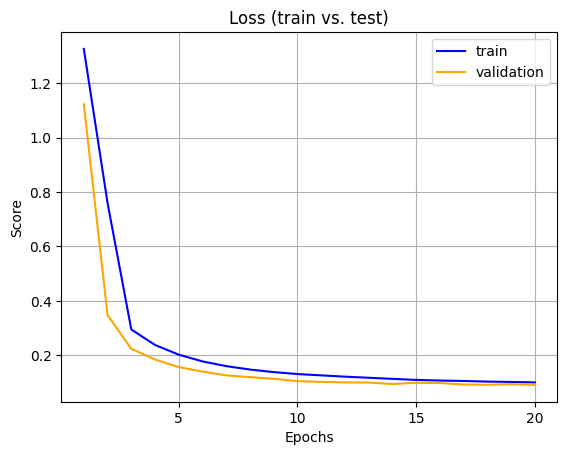

In [12]:
#plot training and validation loss
def plot_graph(train_metric, val_metric, nb_epochs, title):
    x = [int(i) for i in range(1, nb_epochs + 1)]
    plt.plot(x, train_metric, color = 'blue', label = 'train')
    plt.plot(x, val_metric, color = 'orange', label = 'validation')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    x_ticks = [i for i in x if i % 5 == 0]
    plt.title(title)
    plt.xticks(x_ticks)
    plt.grid(True)
    plt.show()

plot_graph(total_train_losses, total_test_losses, num_epochs, 'Loss (train vs. test)')

#### evaluation an visualization

In [13]:
def plot_prediction(sample_preds, sample_x, sample_depth, sample_distribution,
                    pred_locations, true_locations):
    plt.figure(figsize=(15,6))

    # Plotting on the primary y-axis
    # gamma ray
    plt.plot(sample_depth, sample_x * train_std + train_mean, color='black')
    # prediction
    plt.axvline(pred_locations[0], color='red', linestyle = '--', label= 'pred_M')
    plt.axvline(pred_locations[1], color='blue',linestyle = '--', label= 'pred_S')
    plt.axvline(pred_locations[2], color='green', linestyle = '--', label= 'pred_C')
    # ground truth
    plt.axvline(true_locations[0], color='red', label= 'true_M')
    plt.axvline(true_locations[1], color='blue', label= 'true_S')
    plt.axvline(true_locations[2], color='green', label= 'true_C')
    
    plt.xlabel('Depth')
    plt.ylabel('Gamma Ray')
    plt.xticks([i for i in sample_depth if i % 200 == 0])
    plt.grid(True)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)

    # Creating secondary y-axis
    ax2 = plt.gca().twinx()
    # Use the secondary y-axis for the fill_between
    ax2.fill_between(sample_depth, sample_distribution[:,2], color='lightcoral', alpha=0.5, label='Prob_M')
    ax2.fill_between(sample_depth, sample_distribution[:,3], color='lightblue', alpha=0.5, label='Prob_S')
    ax2.fill_between(sample_depth, sample_distribution[:,4], color='lightgreen', alpha=0.5, label='Prob_C')
    ax2.set_ylim(0, 1)  # Setting the range for the secondary y-axis
    ax2.set_ylabel('Probability')

    plt.show()    

In [14]:
def post_process(preds_test, y_test, depth):
    result = []
    for index in range(preds_test.shape[0]):
        sample_distribution = np.array(F.softmax(torch.tensor(preds_test[index]), dim = 1))
        sample_preds = np.argmax(sample_distribution, axis=1)
        sample_y = y_test[index]
        sample_depth = depth_test[index]

        mask = sample_y != 0
        sample_distribution = sample_distribution[mask]
        sample_preds = sample_preds[mask]
        sample_depth = sample_depth[mask]
        sample_y = sample_y[mask]
    
        pred_locations = []
        for i in range(2, 5):
            max_value = np.max(sample_distribution[:,i])
            index_loc = np.where(sample_distribution[:,i] == max_value)[0]
            depths = sample_depth[index_loc]
            depth = statistics.median(depths)
            pred_locations.append(depth)
        result.append(np.array(pred_locations))
    return result 
    
def combine(sample_distribution, sample_depth, search_range = 1):
    # get dictionary for each marker {location: prob}
    search_dicts = []
    for marker_col in range(2, 5):
        loc_prob_dict = {}
        marker_probs = sample_distribution[:,marker_col]
        sort_prob = np.sort(marker_probs)
        top_probs = sort_prob[-search_range:]
        for i in range(search_range):
            prob_value = top_probs[i]
            index_loc = np.where(marker_probs == prob_value)[0]
            depths = sample_depth[index_loc]
            depth = statistics.median(depths)
            loc_prob_dict[depth] = prob_value
        search_dicts.append(loc_prob_dict)

    # compare all possible combination and give the result
    best_combine_prob = 0
    best_combine = None
    combinations = [(x, y, z) 
                    for x in list(search_dicts[0].keys()) 
                    for y in list(search_dicts[1].keys()) 
                    for z in list(search_dicts[2].keys())]
    for i in range(len(combinations)):
        combination = combinations[i]
        marker_M, marker_S, marker_C = combination[0], combination[1], combination[2]
        diff_1 = marker_S - marker_M
        diff_2 = marker_C - marker_S
        if diff_1 > 0 and diff_2 > 0:
            combine_prob = search_dicts[0][marker_M] * \
                            search_dicts[1][marker_S] * \
                            search_dicts[2][marker_C]
            if combine_prob > best_combine_prob:
                best_combine_prob = combine_prob
                best_combine = combination
    return best_combine

def location_search(preds_test, y_test , depth):
    result = []
    # process for each sample
    for index in range(preds_test.shape[0]):
        sample_distribution = np.array(F.softmax(torch.tensor(preds_test[index]), dim = 1))
        sample_preds = np.argmax(sample_distribution, axis=1)
        sample_depth = depth_test[index]
        sample_y = y_test[index]

        mask = (sample_y != 0)
        sample_distribution = sample_distribution[mask]
        sample_preds = sample_preds[mask]
        sample_depth = sample_depth[mask]  
        sample_y = sample_y[mask]    
        
        search_range = 1
        while True:
            pred_locations = combine(sample_distribution, sample_depth, search_range = search_range)
            search_range += 2
            if pred_locations is not None:
                break
        result.append(np.array(pred_locations)) 
    return result

In [15]:
def evaluate(post_process_result, tops_test, tolerance = 15):
    correct = 0
    total = 0
    for index in range(len(post_process_result)): 
        pred_locations = post_process_result[index]
        true_locations = tops_test[index,:]        
        for i in range(3):
            marker = true_locations[i]
            pred_marker = pred_locations[i]
            total += 1
            if abs(marker - pred_marker) <= tolerance:
                correct += 1
                
    accuracy = correct / total
    print(f'Under tolerance {tolerance}, accuracy: {accuracy}')
    return accuracy

def evaluate_total(post_process_result, tops_test):
    tolerance_list = [5, 10, 15, 20]
    for i in range(len(tolerance_list)):
        acc = evaluate(post_process_result, tops_test, 
                       tolerance = tolerance_list[i])
    
    max_error = 0
    error_marcel = 0
    error_sylvain = 0
    error_conrad = 0
    sum_ae = 0
    count = 0
    for index in range(len(post_process_result)): 
        pred_locations = post_process_result[index]
        true_locations = tops_test[index,:]        
        for i in range(3):
            marker = true_locations[i]
            pred_marker = pred_locations[i]
            error = abs(marker - pred_marker)
            if i == 0:
                error_marcel = max(error_marcel, error)
            elif i == 1:
                error_sylvain = max(error_sylvain, error)
            elif i == 2:
                error_conrad = max(error_conrad, error)
            max_error = max(max_error, error)
            count += 1
            sum_ae += error
    print(f'max error Marcel: {error_marcel}')
    print(f'max error Sylvain: {error_sylvain}')
    print(f'max error Conrad: {error_conrad}')
    print(f'100% accuracy tolerance: {max_error}')
    print(f'mean absolute error: {sum_ae / count}')

In [16]:
post_process_result = post_process(preds_test, y_test, depth_test)

In [17]:
print('original post process result:')
evaluate_total(post_process_result, tops_test)

original post process result:
Under tolerance 5, accuracy: 0.8433333333333334
Under tolerance 10, accuracy: 0.91
Under tolerance 15, accuracy: 0.9333333333333333
Under tolerance 20, accuracy: 0.94
max error Marcel: 562.5
max error Sylvain: 21.0
max error Conrad: 157.5
100% accuracy tolerance: 562.5
mean absolute error: 12.413333333333334


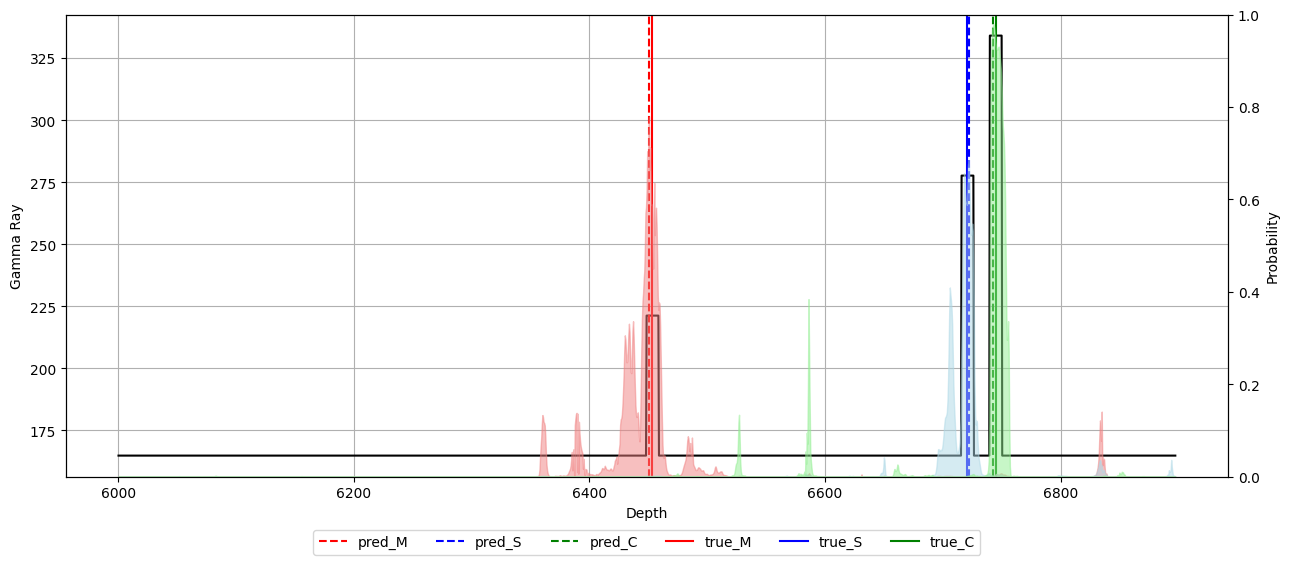

In [18]:
index = 12

sample_distribution = np.array(F.softmax(torch.tensor(preds_test[index]), dim = 1))
sample_preds = np.argmax(sample_distribution, axis=1)
sample_y = y_test[index]
sample_depth = depth_test[index]

mask = sample_y != 0
sample_distribution = sample_distribution[mask]
sample_preds = sample_preds[mask]
sample_depth = sample_depth[mask]
sample_y = sample_y[mask]

# get prediction locations
pred_locations = post_process_result[index]
true_locations = tops_test[index,:]

# plot
plot_prediction(sample_preds, sample_y, sample_depth, sample_distribution,
                    pred_locations, true_locations)

In [19]:
location_search_result = location_search(preds_test, y_test, depth_test)

In [20]:
print('location search result:')
evaluate_total(location_search_result, tops_test)

location search result:
Under tolerance 5, accuracy: 0.8533333333333334
Under tolerance 10, accuracy: 0.9266666666666666
Under tolerance 15, accuracy: 0.95
Under tolerance 20, accuracy: 0.9566666666666667
max error Marcel: 116.5
max error Sylvain: 21.0
max error Conrad: 13.0
100% accuracy tolerance: 116.5
mean absolute error: 5.18


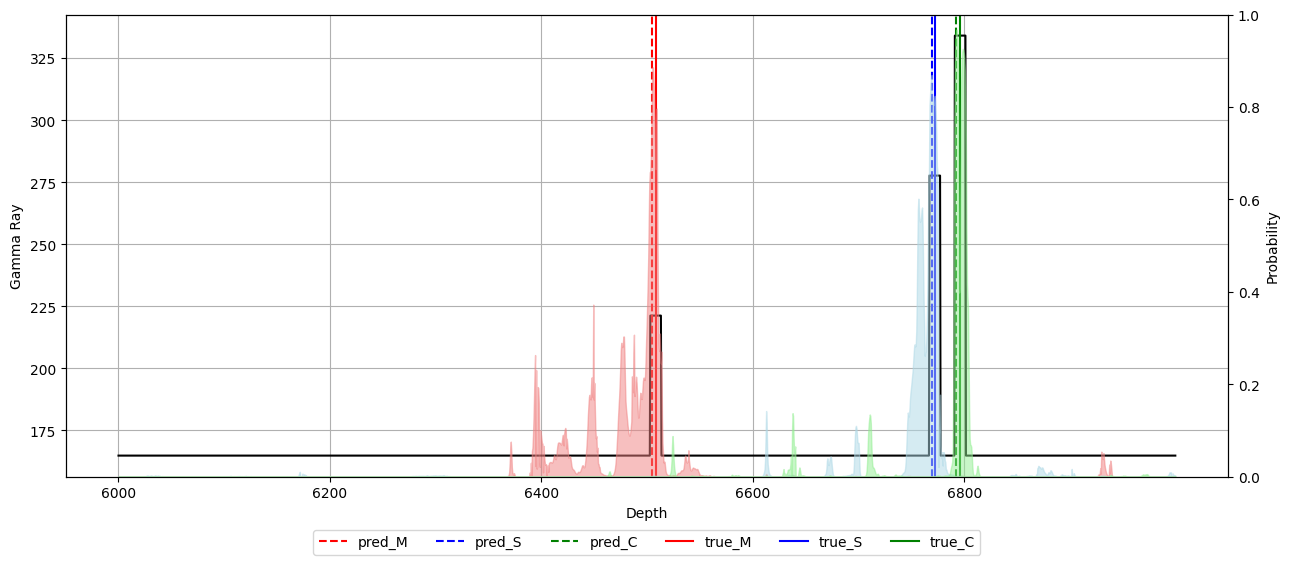

In [21]:
index = 27

sample_distribution = np.array(F.softmax(torch.tensor(preds_test[index]), dim = 1))
sample_preds = np.argmax(sample_distribution, axis=1)
sample_y = y_test[index]
sample_depth = depth_test[index]

mask = sample_y != 0
sample_distribution = sample_distribution[mask]
sample_preds = sample_preds[mask]
sample_depth = sample_depth[mask]
sample_y = sample_y[mask]

# get prediction locations
pred_locations = location_search_result[index]
true_locations = tops_test[index,:]

# plot
plot_prediction(sample_preds, sample_y, sample_depth, sample_distribution,
                    pred_locations, true_locations)